Duvidas atuais:

- StandardScaler: é necessário?
- É necessário quantos modeos?

# The data

In [2]:
import pandas as pd
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')

In [4]:
df = df[['v1', 'v2']]

In [13]:
df

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


# Feature creation

In [10]:
#Substitute point and go to lower case
import re
sms = list(df.v2)
sms = [re.sub('[^A-Za-z]', ' ', s) for s in sms]
sms = [s.lower() for s in sms]

In [14]:
#Remove stopwords
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /home/sergio/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /home/sergio/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [18]:
data = []
for s in sms:
    tokenized_sms = word_tokenize(s)
    for word in tokenized_sms:
        if word in stopwords.words('english'):
            tokenized_sms.remove(word)
        
    s_text = " ".join(tokenized_sms)
    data.append(s_text)

In [19]:
data

['go jurong point crazy available in bugis n great world la e buffet cine got amore wat',
 'ok lar joking wif u oni',
 'free entry a wkly comp win fa cup final tkts st may text fa to receive entry question std txt rate c apply s',
 'u dun say early hor u c already say',
 'nah don think goes usf lives around though',
 'freemsg hey darling week s now no word back d like fun up it still tb ok xxx std chgs send rcv',
 'even brother not like speak treat me like aids patent',
 'per request melle melle oru minnaminunginte nurungu vettam been set callertune all callers press copy your friends callertune',
 'winner a valued network customer have selected receivea prize reward claim call claim code kl valid hours',
 'your mobile months more u r entitled update latest colour mobiles camera free call the mobile update co free',
 'm gon na home soon t want talk this stuff anymore tonight k i ve cried enough today',
 'six chances win cash pounds txt csh send to cost p day days tsandcs apply reply hl

In [24]:
#Bag of words
from sklearn.feature_extraction.text import CountVectorizer

In [25]:
#Pega todas as palavras em cada SMS e depois conta o número de ocorrencias de cada uma
#Depois selecionamos as palavras que aparecem mais que outras. Exemplo: selecionar as primeiras X palavras
matrix = CountVectorizer(max_features=1000)
X = matrix.fit_transform(data).toarray()
y = df.iloc[:, 0]

# Model

## First model -> GaussianNB

I'll Fine tune var_smoothing parameter. var_smoothing parameter is responsible to add a user-defined value to distribution variance in order to smooth or wide the gaussian curver that will be fit.

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [56]:
# Primeiro Modelo: Naive Bayes Classifier
import time
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
import numpy as np

gnb = GaussianNB()
params = {'var_smoothing': np.logspace(0,-9, num=10)}

gs = GridSearchCV(estimator=gnb, param_grid=params)
start = time.time()
gs.fit(X_train, y_train)
stop = time.time()
print(f"Training time: {stop - start}s")

Training time: 2.897944927215576s


In [59]:
gnb = gs.best_estimator_
gnb.fit(X_train, y_train)

GaussianNB(var_smoothing=0.1)

Now, I'll evaluate the model -> ROC/AUC score and Confusion Matrix

In [60]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score, average_precision_score

In [65]:
y_pred_class = gnb.predict(X_test)

In [76]:
accuracy = accuracy_score(y_test, y_pred_class)
recall = recall_score(y_test, y_pred_class, average='binary', pos_label='ham')
precision = precision_score(y_test, y_pred_class,  average='binary', pos_label='ham')
f1 = f1_score(y_test, y_pred_class,  average='binary', pos_label='ham')

print('f1 score:', f1)
print('precision:', precision)
print('recall:', recall)
print('accuracy', accuracy)

f1 score: 0.9906007355946056
precision: 0.9845653939886271
recall: 0.9967105263157895
accuracy 0.9834888729361091


<AxesSubplot:>

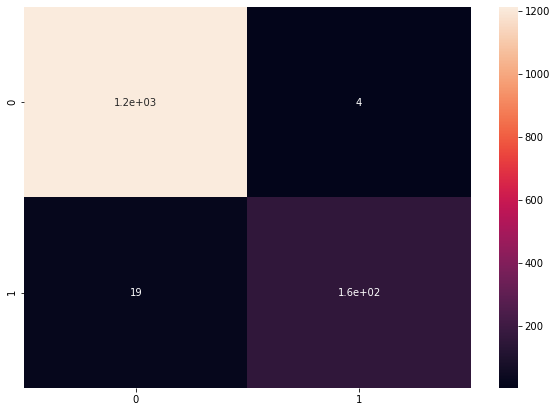

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred_class), index = [0,1],columns = [0,1])


# TN FP
# FN TP
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)

## Second model -> SVM 

I'll Fine tune three parameter of SVM:

- Kernels: transform a low dimension input space in higher dimensional input space
- C: misclassification parameter. Tells SVM how much error is acceptable.
- Gamma: defines how far points influence in line separation.

In [81]:
from sklearn.svm import SVC  
svm = SVC()
params = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}

gs = GridSearchCV(estimator=svm, param_grid=params)
start = time.time()
gs.fit(X_train, y_train)
stop = time.time()
print(f"Training time: {stop - start}s")

Training time: 558.2925717830658s


In [82]:
svm = gs.best_estimator_
svm.fit(X_train, y_train)

SVC(C=10, gamma=0.01)

In [83]:
y_pred_class = svm.predict(X_test)

In [84]:
accuracy = accuracy_score(y_test, y_pred_class)
recall = recall_score(y_test, y_pred_class, average='binary', pos_label='ham')
precision = precision_score(y_test, y_pred_class,  average='binary', pos_label='ham')
f1 = f1_score(y_test, y_pred_class,  average='binary', pos_label='ham')

print('f1 score:', f1)
print('precision:', precision)
print('recall:', recall)
print('accuracy', accuracy)

f1 score: 0.990623726049735
precision: 0.9822150363783346
recall: 0.9991776315789473
accuracy 0.9834888729361091


<AxesSubplot:>

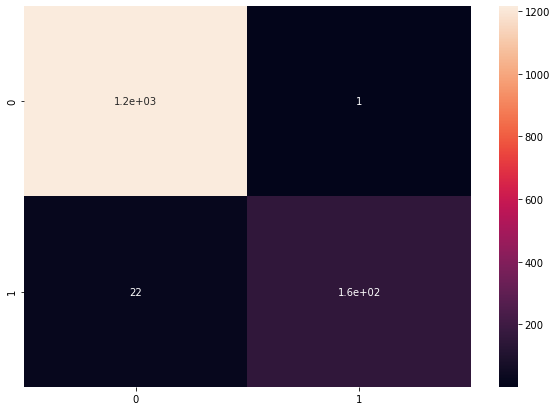

In [85]:
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred_class), index = [0,1],columns = [0,1])


# TN FP
# FN TP
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)

## Third model -> Random Forest

I'll Fine tune four parameters of RF:

- n_estimators: number of trees in the forest
- max_features: number of features considered to split a node
- max_depth: max depth of each tree
- min_samples_leaf: min number of data points in leaf node

In [89]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

params= {
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'n_estimators': [100, 200, 300, 1000]
}

gs = GridSearchCV(estimator=rf, param_grid=params)
start = time.time()
gs.fit(X_train, y_train)
stop = time.time()
print(f"Training time: {stop - start}s")

Training time: 607.2974247932434s


In [90]:
rf = gs.best_estimator_
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=100, max_features=3, min_samples_leaf=3)

In [91]:
y_pred_class = rf.predict(X_test)

In [92]:
accuracy = accuracy_score(y_test, y_pred_class)
recall = recall_score(y_test, y_pred_class, average='binary', pos_label='ham')
precision = precision_score(y_test, y_pred_class,  average='binary', pos_label='ham')
f1 = f1_score(y_test, y_pred_class,  average='binary', pos_label='ham')

print('f1 score:', f1)
print('precision:', precision)
print('recall:', recall)
print('accuracy', accuracy)

f1 score: 0.9716340391530164
precision: 0.9448329448329449
recall: 1.0
accuracy 0.9490308686288585


<AxesSubplot:>

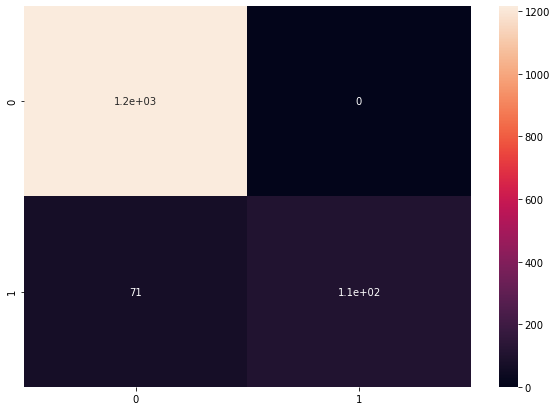

In [93]:
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred_class), index = [0,1],columns = [0,1])


# TN FP
# FN TP
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)

## Fourth model -> Log Reg

I'll Fine tune C parameter of logreg, which is the one that controls regularization. Lower C, more regularization we add to the model.


In [96]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=100000)

params = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }

gs = GridSearchCV(estimator=logreg, param_grid=params)
start = time.time()
gs.fit(X_train, y_train)
stop = time.time()
print(f"Training time: {stop - start}s")

Training time: 5.619571924209595s


In [97]:
logreg = gs.best_estimator_
logreg.fit(X_train, y_train)

LogisticRegression(C=10, max_iter=100000)

In [98]:
y_pred_class = logreg.predict(X_test)

In [99]:
accuracy = accuracy_score(y_test, y_pred_class)
recall = recall_score(y_test, y_pred_class, average='binary', pos_label='ham')
precision = precision_score(y_test, y_pred_class,  average='binary', pos_label='ham')
f1 = f1_score(y_test, y_pred_class,  average='binary', pos_label='ham')

print('f1 score:', f1)
print('precision:', precision)
print('recall:', recall)
print('accuracy', accuracy)

f1 score: 0.9885714285714287
precision: 0.9813614262560778
recall: 0.9958881578947368
accuracy 0.9798994974874372


<AxesSubplot:>

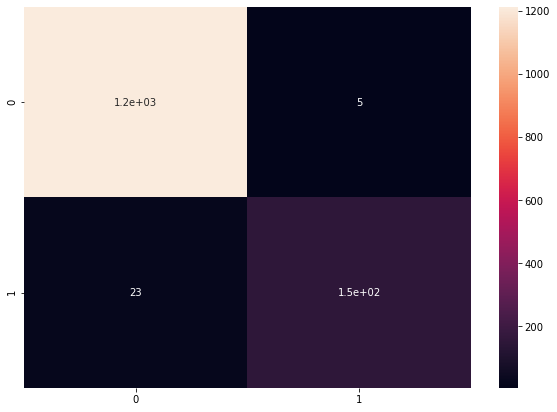

In [100]:
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred_class), index = [0,1],columns = [0,1])


# TN FP
# FN TP
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)

## Fifth model -> MLP

I'll Fine tune four parameters of MLP:

- hidden_layer_sizes: o tamanho das camadas hidden
- alpha: parametro de regularização
- activation: função de ativação

In [101]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(max_iter=100000)

params = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'alpha': [0.0001, 0.05],
}

gs = GridSearchCV(estimator=mlp, param_grid=params)
start = time.time()
gs.fit(X_train, y_train)
stop = time.time()
print(f"Training time: {stop - start}s")

/home/sergio/.local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/sergio/.local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/sergio/.local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/sergio/.local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  %

Training time: 223.69708442687988s


In [102]:
mlp = gs.best_estimator_
mlp.fit(X_train, y_train)

MLPClassifier(max_iter=100)

In [103]:
y_pred_class = mlp.predict(X_test)

In [104]:
accuracy = accuracy_score(y_test, y_pred_class)
recall = recall_score(y_test, y_pred_class, average='binary', pos_label='ham')
precision = precision_score(y_test, y_pred_class,  average='binary', pos_label='ham')
f1 = f1_score(y_test, y_pred_class,  average='binary', pos_label='ham')

print('f1 score:', f1)
print('precision:', precision)
print('recall:', recall)
print('accuracy', accuracy)

f1 score: 0.9898000815993472
precision: 0.9821862348178138
recall: 0.9975328947368421
accuracy 0.9820531227566404


<AxesSubplot:>

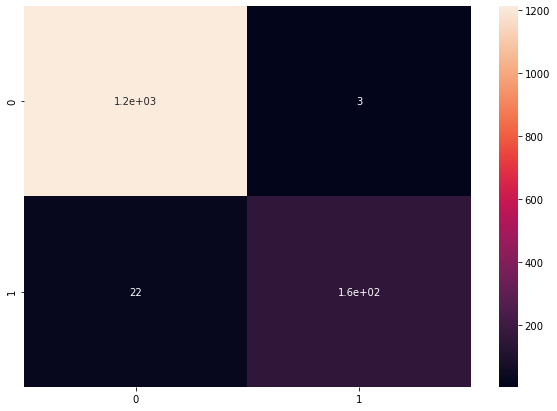

In [105]:
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred_class), index = [0,1],columns = [0,1])


# TN FP
# FN TP
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)